In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
root = "C:/Users/HUBFU/OneDrive/Documents/Always Her song data/"

silhouette = pd.read_csv(root + "Silhouette (The Halloween Song)-timeline.csv")
itb = pd.read_csv(root + "In the Beginning-timeline.csv")
erberger = pd.read_csv(root + "Airport Girl-timeline.csv")
mr_nice_guy = pd.read_csv(root + "Mr. Nice Guy-timeline.csv")
my_brain = pd.read_csv(root + "My Brain Is Carrying the World-timeline.csv")
olay = pd.read_csv(root + "One Look at You - Acoustic-timeline.csv")
prolly_nun = pd.read_csv(root + "Probably Nothing - Acoustic-timeline.csv")
savior = pd.read_csv(root + "Savior - Acoustic-timeline.csv")
itb_acous = pd.read_csv(root + "In the Beginning - Acoustic-timeline.csv")
erberger_acous = pd.read_csv(root + "Airport Girl - Acoustic-timeline.csv")
timeless = pd.read_csv(root + "Timeless-timeline.csv")

In [3]:
silhouette['song'] = 'Silhouette'
itb['song'] = 'In the Beginning'
erberger['song'] = 'Airport Girl'
mr_nice_guy['song'] = 'Mr. Nice Guy'
my_brain['song'] = 'My Brain Is Carrying the World'
olay['song'] = 'One Look At You'
prolly_nun['song'] = 'Probably Nothing (Acoustic)'
savior['song'] = 'Savior (Acoustic)'
itb_acous['song'] = 'In the Beginning (Acoustic)'
erberger_acous['song'] = 'Airport Girl (Acoustic)'
timeless['song'] = 'Timeless'

In [4]:
combined_songs = pd.concat([silhouette, itb, erberger, mr_nice_guy, my_brain,
                            olay, prolly_nun, savior, itb_acous, erberger_acous, timeless])

combined_songs['date'] = pd.to_datetime(combined_songs['date'])

In [5]:
filtered_df = combined_songs[combined_songs['date'] >= '2024-04-21']

#filtered_df = combined_songs[combined_songs['song'] != 'Silhouette']

#filtered_df = combined_songs[combined_songs['streams'] < 80]

In [6]:
filtered_df['week'] = filtered_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_df = filtered_df.groupby(['song', 'week'])['streams'].sum().reset_index()

C:\Users\HUBFU\AppData\Local\Temp\ipykernel_267204\1342388671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['week'] = filtered_df['date'].dt.to_period('W').apply(lambda r: r.start_time)


In [7]:
def filter_zeros_before_release(df):
    """
    For each song, keep the week immediately before the release week and all subsequent weeks.
    """
    filtered_dfs = []
    
    for song, song_data in df.groupby('song'):
        song_data = song_data.sort_values('week').reset_index(drop=True)
        first_stream_week_idx = song_data.loc[song_data['streams'] > 0].index.min()
        prior_week_idx = max(first_stream_week_idx - 1, 0)
        filtered_song_data = song_data.loc[prior_week_idx:]
        
        filtered_dfs.append(filtered_song_data)

    return pd.concat(filtered_dfs)

filtered_df2 = filter_zeros_before_release(weekly_df)

In [8]:
cumulative_df = filtered_df2.groupby('song').apply(
    lambda x: x.sort_values('week').assign(cumulative_streams=x['streams'].cumsum())
).reset_index(drop=True)

C:\Users\HUBFU\AppData\Local\Temp\ipykernel_267204\770794914.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cumulative_df = filtered_df2.groupby('song').apply(


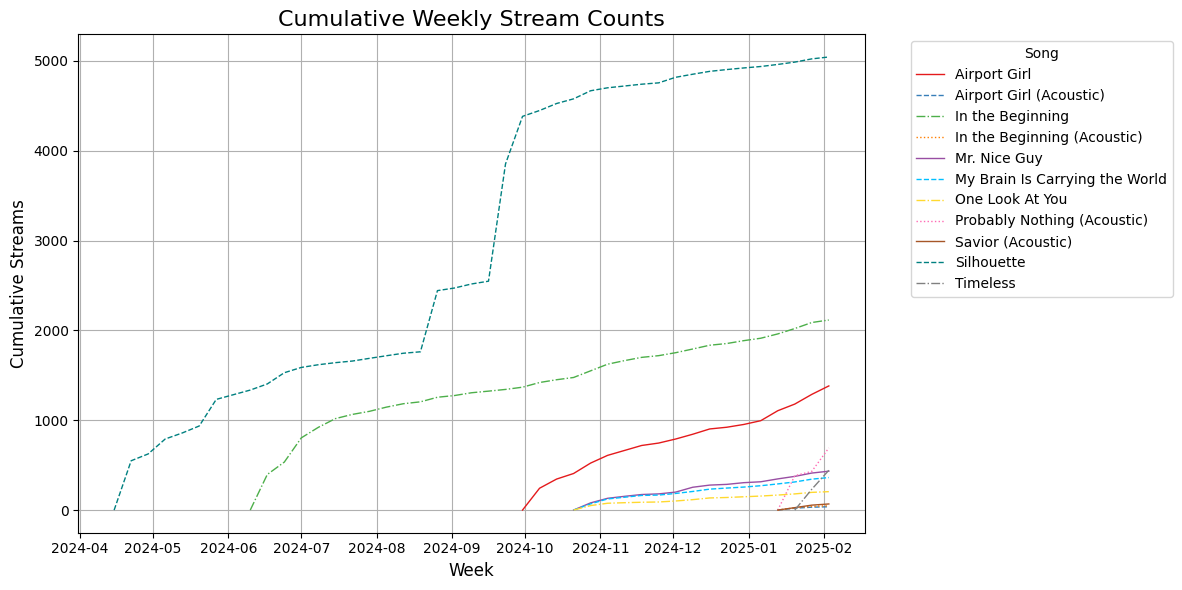

In [9]:
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.']

colors = [
    (228/255, 26/255, 28/255),    # Red
    (55/255, 126/255, 184/255),   # Blue
    (77/255, 175/255, 74/255),    # Green
    (255/255, 127/255, 0/255),    # Orange
    (152/255, 78/255, 163/255),   # Purple
    (0/255, 191/255, 255/255),    # Cyan
    (255/255, 217/255, 47/255),   # Yellow
    (255/255, 105/255, 180/255),  # Pink
    (166/255, 86/255, 40/255),    # Brown
    (0/255, 128/255, 128/255),    # Teal
    (128/255, 128/255, 128/255)   # Gray
]

plt.figure(figsize=(12, 6))

for idx, (song, song_data) in enumerate(cumulative_df.groupby('song')):
    plt.plot(song_data['week'], song_data['cumulative_streams'], 
             label=song, 
             linestyle=line_styles[idx % len(line_styles)],  
             color=colors[idx % len(colors)],                
             linewidth=1)                                    

plt.title('Cumulative Weekly Stream Counts', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Cumulative Streams', fontsize=12)
plt.legend(title='Song', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()


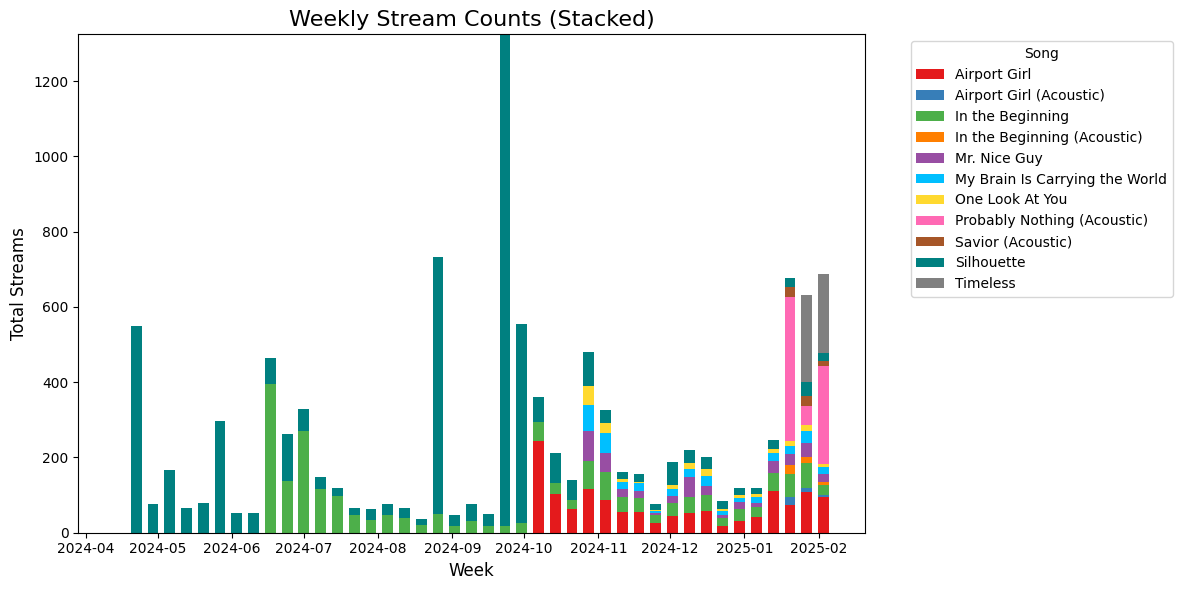

In [10]:
pivot_df = filtered_df2.pivot(index='week', columns='song', values='streams').fillna(0)

pivot_df = pivot_df.sort_index()


plt.figure(figsize=(12, 6))

bottom = pd.Series([0] * len(pivot_df), index=pivot_df.index)

for idx, song in enumerate(pivot_df.columns):
    plt.bar(pivot_df.index, pivot_df[song], 
            bottom=bottom, 
            label=song,
            color=colors[idx % len(colors)],
            width=4.5)

    bottom += pivot_df[song]

plt.title('Weekly Stream Counts (Stacked)', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Total Streams', fontsize=12)
plt.legend(title='Song', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

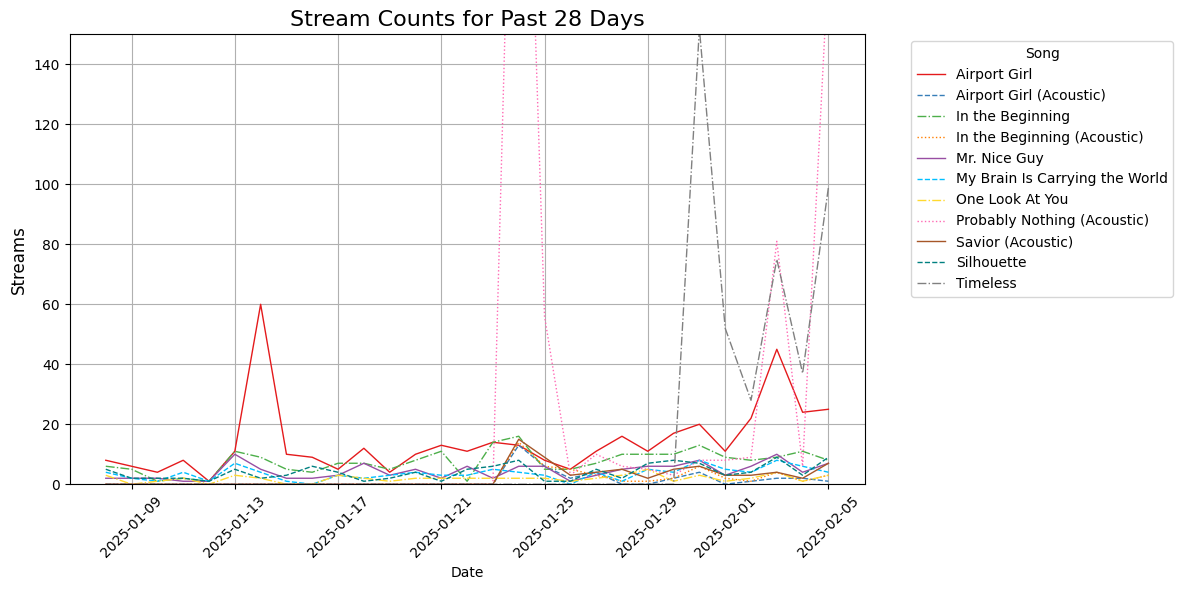

In [12]:
from datetime import timedelta


latest_date = filtered_df['date'].max()

past_21_days_df = filtered_df[filtered_df['date'] >= (latest_date - timedelta(days=28))]

plt.figure(figsize=(12, 6))

for idx, (song, song_data) in enumerate(past_21_days_df.groupby('song')):
    plt.plot(song_data['date'], song_data['streams'], 
             label=song, 
             linestyle=line_styles[idx % len(line_styles)],  
             color=colors[idx % len(colors)],                
             linewidth=1)                                    

plt.title('Stream Counts for Past 28 Days', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Streams', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 150) 
plt.legend(title='Song', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()